# Transcription Factor Activities  

Here we infer transcription factor (TF) activities from our spatial transcriptomics data. To do that, we need a gene regulatory network (GRN). 

1. We used CollecTRI, a comprehensive resource containing a curated collection of TFs and their transcriptional targets compiled from 12 different resources. This collection provides an increased coverage of transcription factors and a superior performance in identifying perturbed TFs. Interactions are weighted by their mode of regulation (activation or inhibition).
2. We could use other GRN coming from an inference methods such as CellOracle, pySCENIC or SCENIC+

### Load packages  

Environment ``liana``

In [1]:
# Generic
import pandas as pd
import numpy as np

# single cell
import scanpy as sc
import squidpy as sq
import decoupler as dc
import plotnine as p9
import liana as li
import anndata as ad

### Load and normalize data

In [2]:
folder = '/lustre/groups/ml01/workspace/sara.jimenez/spatial_pancreas_data/preprocessed_data/data4downstream/'
files   = ['s1_covet_niche_def_corr_per_fov.h5ad','s2_covet_niche_def_corr_per_fov.h5ad','s3_covet_niche_def_corr_per_fov.h5ad']

s1 = sc.read_h5ad(folder+files[0])
#s1.obs["fov"] = s1.obs["fov"].astype(str) + "_s1"
s2 = sc.read_h5ad(folder+files[1])
#s2.obs["fov"] = s2.obs["fov"].astype(str) + "_s2"
s3 = sc.read_h5ad(folder+files[2])
#s3.obs["fov"] = s3.obs["fov"].astype(str) + "_s3"

adata = ad.concat([s1, s2, s3], join='outer',uns_merge='same',axis=0,pairwise=True) 
del s1 
del s2
del s3
adata

/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


AnnData object with n_obs × n_vars = 386727 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse', 'CellTypes_max', 'donor', 'cell_type', 'leiden_covet_0.2', 'Niche_label'
    uns: 'CellTypes_max_colors', 'Niche_label_colors', 'cell_type_coarse_colors', 'hvg', 'leiden_covet_0.2', 'n_neighbors=30', 'neighbors', 'pca', 'spatial'
    obsm: 'X_pca', 'X_umap', 'covet-n_neighbors=30', 'covet_sqrt-n_neighbors=30', 'covet_sqrt_flat-n_neighbors=30', 'spatial', 'spati

In [3]:
adata.X.max(),adata.layers['counts'].max()

(122.07407, 325)

The data is already normalized

### Spatial neighbors

In [4]:
adata.obs['fov_unique'] = adata.obs.fov.astype(str) + '_' + adata.obs.slide.astype(str)
adata.obs.fov_unique.unique()

array(['1_Run5211_S1', '2_Run5211_S1', '3_Run5211_S1', '4_Run5211_S1',
       '5_Run5211_S1', '6_Run5211_S1', '7_Run5211_S1', '8_Run5211_S1',
       '9_Run5211_S1', '10_Run5211_S1', '11_Run5211_S1', '12_Run5211_S1',
       '13_Run5211_S1', '14_Run5211_S1', '15_Run5211_S1', '16_Run5211_S1',
       '17_Run5211_S1', '18_Run5211_S1', '19_Run5211_S1', '20_Run5211_S1',
       '21_Run5211_S1', '22_Run5211_S1', '23_Run5211_S1', '24_Run5211_S1',
       '1_Run5211_S2', '2_Run5211_S2', '3_Run5211_S2', '4_Run5211_S2',
       '5_Run5211_S2', '6_Run5211_S2', '7_Run5211_S2', '8_Run5211_S2',
       '9_Run5211_S2', '10_Run5211_S2', '11_Run5211_S2', '12_Run5211_S2',
       '13_Run5211_S2', '14_Run5211_S2', '15_Run5211_S2', '16_Run5211_S2',
       '17_Run5211_S2', '18_Run5211_S2', '19_Run5211_S2', '20_Run5211_S2',
       '21_Run5211_S2', '22_Run5211_S2', '1_Run5211_S3', '2_Run5211_S3',
       '3_Run5211_S3', '4_Run5211_S3', '5_Run5211_S3', '6_Run5211_S3',
       '7_Run5211_S3', '8_Run5211_S3', '9_Run5211

In [5]:
adata.obs['fov_unique'] = adata.obs['fov_unique'].astype('category')

In [6]:
sq.gr.spatial_neighbors(adata, spatial_key='spatial',library_key='fov_unique',n_neighs=30)#,delaunay=True)
adata

AnnData object with n_obs × n_vars = 386727 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse', 'CellTypes_max', 'donor', 'cell_type', 'leiden_covet_0.2', 'Niche_label', 'fov_unique'
    uns: 'CellTypes_max_colors', 'Niche_label_colors', 'cell_type_coarse_colors', 'hvg', 'leiden_covet_0.2', 'n_neighbors=30', 'neighbors', 'pca', 'spatial', 'spatial_neighbors'
    obsm: 'X_pca', 'X_umap', 'covet-n_neighbors=30', 'covet_sqrt-n_neighbors=30', 'covet_sqrt_flat

### TF activity inference with own GRN from multiome data

In [7]:
grn_file = '/lustre/groups/ml01/datasets/projects/20230301_Sander_SpatialPancreas_sara.jimenez/spatial/GRNs_wWeight_allCT.txt'
grn = pd.read_csv(grn_file, delimiter='\t')
grn

cell_type      TF    gene  weight
0        basalAcinar    ELF3  FAM41C       1
1        basalAcinar    ELK4  FAM41C       1
2        basalAcinar     REL  FAM41C       1
3        basalAcinar   CREB1  FAM41C       1
4        basalAcinar    THRB  FAM41C       1
...              ...     ...     ...     ...
9484217       Tcells    MZF1    IL9R       1
9484218       Tcells  ZNF341    IL9R       1
9484219       Tcells   TCFL5    IL9R       1
9484220       Tcells    TFE3    IL9R       1
9484221       Tcells  ZNF449    IL9R       1

[9484222 rows x 4 columns]

In [8]:
# Define the replacements as a dictionary
replacements = {
    'basalAcinar': 'Acinar_basal',
    'signalAcinar': 'Acinar_signal',
    'highEnzAcinar': 'Acinar_highEnz',
    'signalDiffAcinar': 'Acinar_sigdiff'
}

# Replace the entries in the 'cell_type' column
grn['cell_type'] = grn['cell_type'].replace(replacements)

In [9]:
# Get categories of 'CellTypes_max' from the AnnData object
celltypes_max_categories = adata.obs['CellTypes_max'].cat.categories

# Get unique categories of 'cell_type' from the grn DataFrame
cell_type_categories = grn['cell_type'].unique()

matches = set(celltypes_max_categories) & set(cell_type_categories)
matches

{'Acinar_basal',
 'Acinar_highEnz',
 'Acinar_sigdiff',
 'Acinar_signal',
 'Activated_Stellate',
 'Alpha',
 'Beta',
 'Ductal',
 'Endothelial',
 'Macrophage',
 'Quiescent_Stellate',
 'Tcells'}

In [10]:
adatas_grn = []
for ct in matches:
    grn_subset = grn[grn['cell_type'] == ct]
    adata_subset = adata[adata.obs['CellTypes_max'] == ct].copy()
    dc.run_ulm(
        mat=adata_subset,
        net=grn_subset,
        source='TF',
        target='gene',
        weight='weight',
        verbose=True,
        use_raw=False
    )
    adatas_grn.append(adata_subset)       
    del adata_subset   
#adata = ad.concat(adatas_grn, join='outer',uns_merge='same',axis=0,pairwise=True)  

/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Running ulm on mat with 33504 samples and 979 targets for 222 sources.


/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Running ulm on mat with 70553 samples and 979 targets for 226 sources.


/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Running ulm on mat with 17168 samples and 979 targets for 283 sources.


/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Running ulm on mat with 56478 samples and 979 targets for 253 sources.


/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Running ulm on mat with 10522 samples and 979 targets for 254 sources.


/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Running ulm on mat with 32266 samples and 979 targets for 219 sources.


/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Running ulm on mat with 15050 samples and 979 targets for 270 sources.


/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Running ulm on mat with 17466 samples and 979 targets for 249 sources.


/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Running ulm on mat with 17212 samples and 979 targets for 278 sources.


/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Running ulm on mat with 18803 samples and 979 targets for 240 sources.


/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Running ulm on mat with 14311 samples and 979 targets for 246 sources.


/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Running ulm on mat with 65455 samples and 979 targets for 228 sources.


In [11]:
adata = ad.concat(adatas_grn, join='outer',uns_merge='same',axis=0,pairwise=True) 

/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [12]:
adata

AnnData object with n_obs × n_vars = 368788 × 979
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse', 'CellTypes_max', 'donor', 'cell_type', 'leiden_covet_0.2', 'Niche_label', 'fov_unique'
    uns: 'Niche_label_colors', 'hvg', 'leiden_covet_0.2', 'n_neighbors=30', 'neighbors', 'pca', 'spatial', 'spatial_neighbors'
    obsm: 'X_pca', 'X_umap', 'covet-n_neighbors=30', 'covet_sqrt-n_neighbors=30', 'covet_sqrt_flat-n_neighbors=30', 'spatial', 'spatial_fov', 'ulm_es

In [13]:
acts = dc.get_acts(adata, obsm_key='ulm_estimate')

/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [14]:
acts

AnnData object with n_obs × n_vars = 368788 × 366
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse', 'CellTypes_max', 'donor', 'cell_type', 'leiden_covet_0.2', 'Niche_label', 'fov_unique'
    uns: 'Niche_label_colors', 'hvg', 'leiden_covet_0.2', 'n_neighbors=30', 'neighbors', 'pca', 'spatial', 'spatial_neighbors'
    obsm: 'X_pca', 'X_umap', 'covet-n_neighbors=30', 'covet_sqrt-n_neighbors=30', 'covet_sqrt_flat-n_neighbors=30', 'spatial', 'spatial_fov', 'ulm_es

In [15]:
acts.obs_names_make_unique

<bound method AnnData.obs_names_make_unique of AnnData object with n_obs × n_vars = 368788 × 366
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse', 'CellTypes_max', 'donor', 'cell_type', 'leiden_covet_0.2', 'Niche_label', 'fov_unique'
    uns: 'Niche_label_colors', 'hvg', 'leiden_covet_0.2', 'n_neighbors=30', 'neighbors', 'pca', 'spatial', 'spatial_neighbors'
    obsm: 'X_pca', 'X_umap', 'covet-n_neighbors=30', 'covet_sqrt-n_neighbors=30', 'covet_sqrt_flat-n_n

/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/squidpy/pl/_color_utils.py:28: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.


/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored


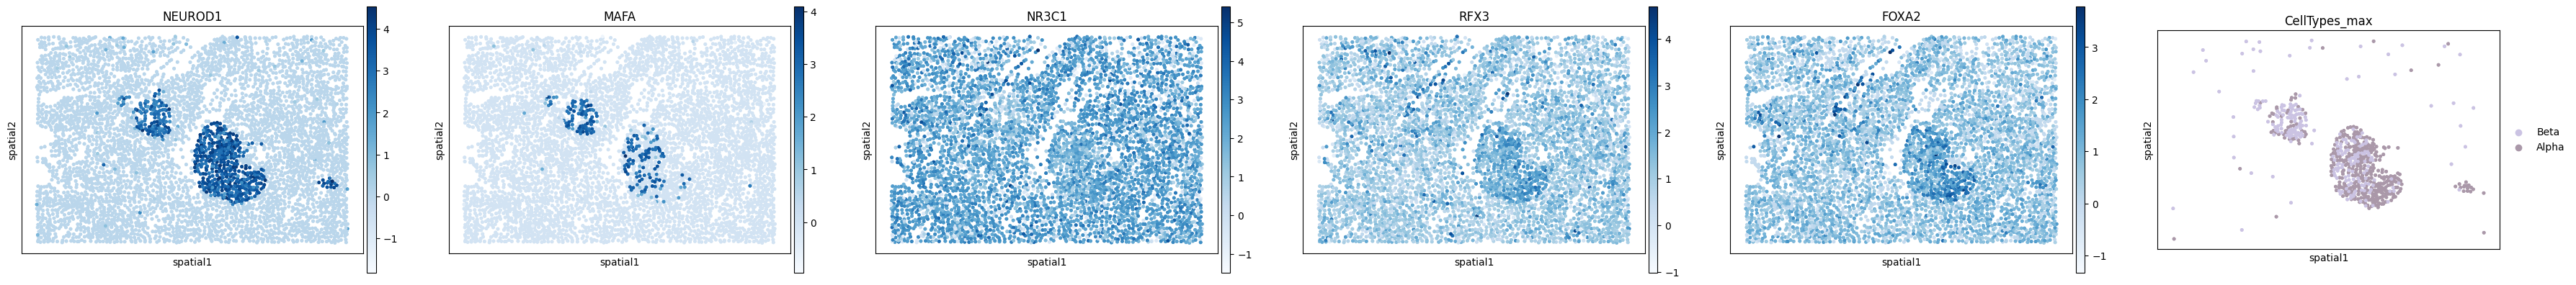

In [42]:
# Check how the TF activities look like
sq.pl.spatial_scatter(
    acts[acts.obs['fov_unique'] == '12_Run5211_S1'],
    color = ['NEUROD1', 'MAFA','NR3C1','RFX3','FOXA2','CellTypes_max'],
    groups = ['Alpha','Beta','Delta'],
    spatial_key = 'spatial',
    shape=None,
    cmap='Blues',
    ncols=6,
    #vmax="p99",
)

/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/squidpy/pl/_color_utils.py:28: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored


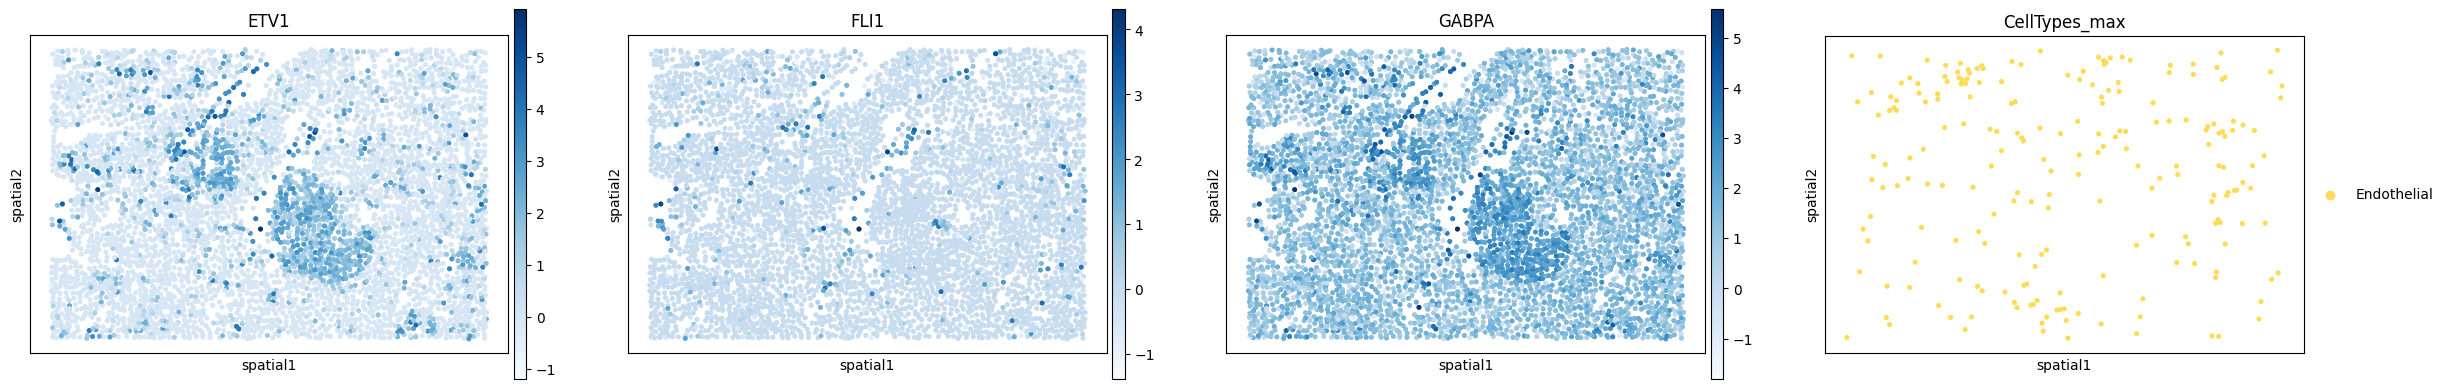

In [43]:
# Check how the TF activities look like
sq.pl.spatial_scatter(
    acts[acts.obs['fov_unique'] == '12_Run5211_S1'],
    color = ['ETV1', 'FLI1', 'GABPA','CellTypes_max'],
    groups = ['Endothelial'],
    spatial_key = 'spatial',
    shape=None,
    cmap='Blues',
    ncols=6,
    #vmax="p99",
)

/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/squidpy/pl/_color_utils.py:28: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored


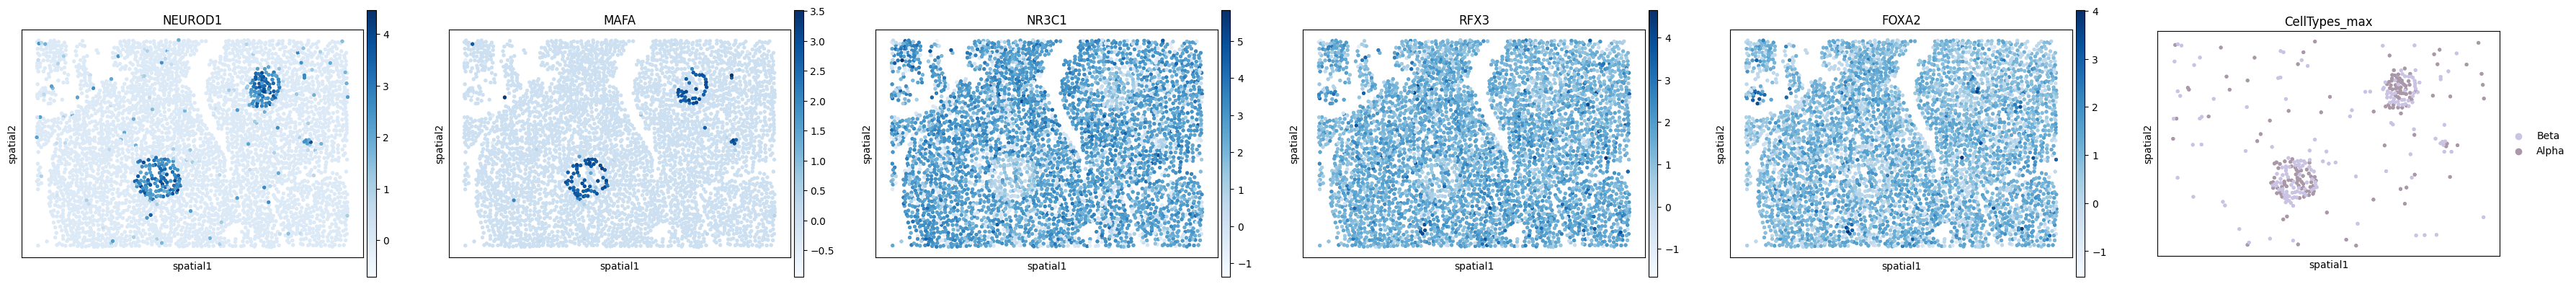

In [44]:
# Check how the TF activities look like
sq.pl.spatial_scatter(
                acts[acts.obs['fov_unique'] == '10_Run5211_S1'],
                color = ['NEUROD1', 'MAFA','NR3C1','RFX3','FOXA2','CellTypes_max'],
                groups = ['Alpha','Beta','Delta'],
                spatial_key = 'spatial',
                shape=None,
                cmap='Blues',ncols=6
    )

/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/squidpy/pl/_color_utils.py:28: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored


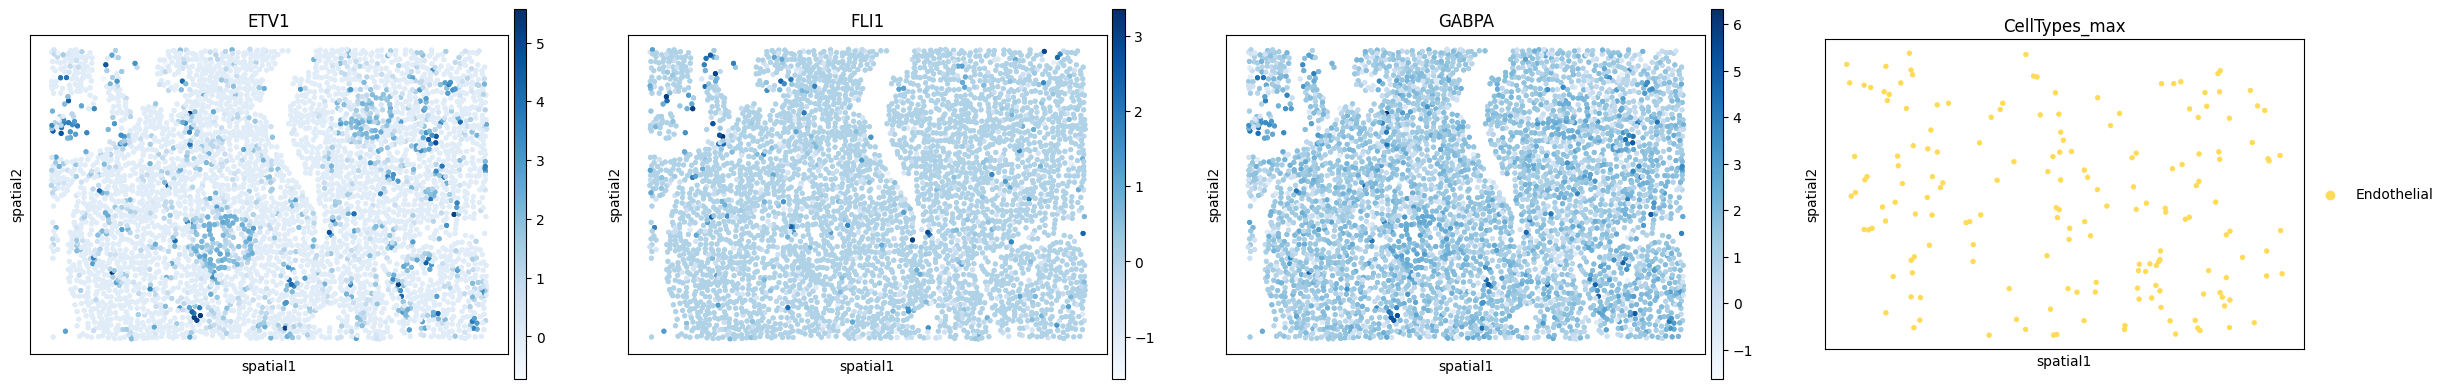

In [45]:
# Check how the TF activities look like
sq.pl.spatial_scatter(
    acts[acts.obs['fov_unique'] == '10_Run5211_S1'],
    color = ['ETV1', 'FLI1', 'GABPA','CellTypes_max'],
    groups = ['Endothelial'],
    spatial_key = 'spatial',
    shape=None,
    cmap='Blues',
    ncols=6,
    #vmax="p99",
)

### TF activity inference with GRN from collecTRI database

In [37]:
net = dc.get_collectri(organism='human', split_complexes=False)
net

/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
Failed to download from `https://omnipathdb.org/`.
Traceback (most recent call last):
  File "/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/urllib3/connectionpool.py", line 715, in urlopen
    httplib_response = self._make_request(
  File "/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/urllib3/connectionpool.py", line 404, in _make_request
    self._validate_conn(conn)
  File "/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/urllib3/connectionpool.py", line 1058, in _validate_conn
    conn.connect()
  File "/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/urllib3/connection.py", line 419, in connect
    self.sock = ssl_wrap_socket(
  File "/home/aih/sara.jimenez/

source          target  weight  \
0         MYC            TERT       1   
1        SPI1           BGLAP       1   
2       SMAD3             JUN       1   
3       SMAD4             JUN       1   
4      STAT5A             IL2       1   
...       ...             ...     ...   
43173    NFKB  hsa-miR-143-3p       1   
43174     AP1     hsa-miR-206       1   
43175    NFKB   hsa-miR-21-5p       1   
43176    NFKB  hsa-miR-224-5p       1   
43177     AP1     hsa-miR-144       1   

                                                    PMID  
0      10022128;10491298;10606235;10637317;10723141;1...  
1                                               10022617  
2                                      10022869;12374795  
3                                      10022869;12374795  
4      10022878;11435608;17182565;17911616;22854263;2...  
...                                                  ...  
43173                                           19472311  
43174                                           19721712  
43175                                  20813833;22387281  
43176                                  23474441;23988648  
43177                                           23546882  

[43178 rows x 4 columns]

In [38]:
dc.run_ulm(
    mat=adata,
    net=net,
    source='source',
    target='target',
    weight='weight',
    verbose=True,
    use_raw=False
)

Running ulm on mat with 368788 samples and 979 targets for 469 sources.


In [39]:
acts_2 = dc.get_acts(adata, obsm_key='ulm_estimate')

/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
... storing 'cell_type_coarse' as categorical
/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are

/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored


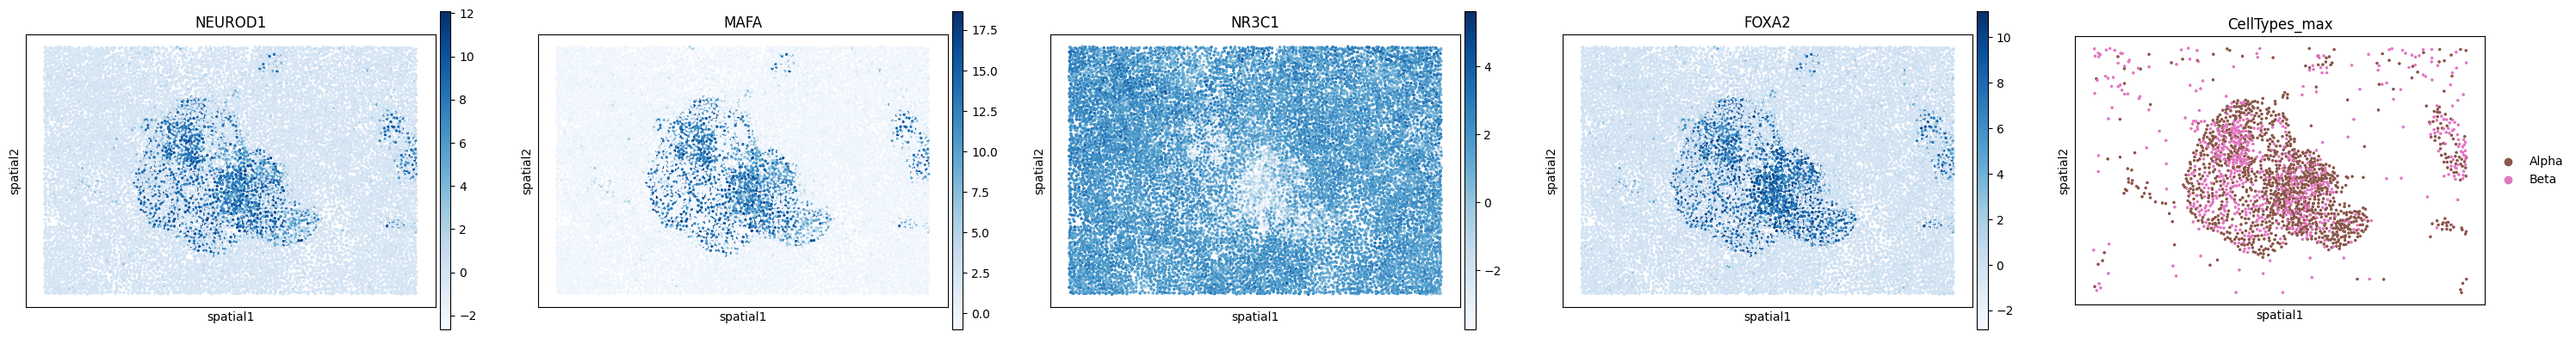

In [41]:
# Check how the TF activities look like
sq.pl.spatial_scatter(
    acts_2[acts_2.obs['fov'] == '12'],
    color = ['NEUROD1', 'MAFA','NR3C1','FOXA2','CellTypes_max'],
    groups = ['Alpha','Beta','Delta'],
    spatial_key = 'spatial',
    shape=None,
    cmap='Blues',
    ncols=6,
    #vmax="p99",
)

/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
... storing 'cell_type_coarse' as categorical
/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are

/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored


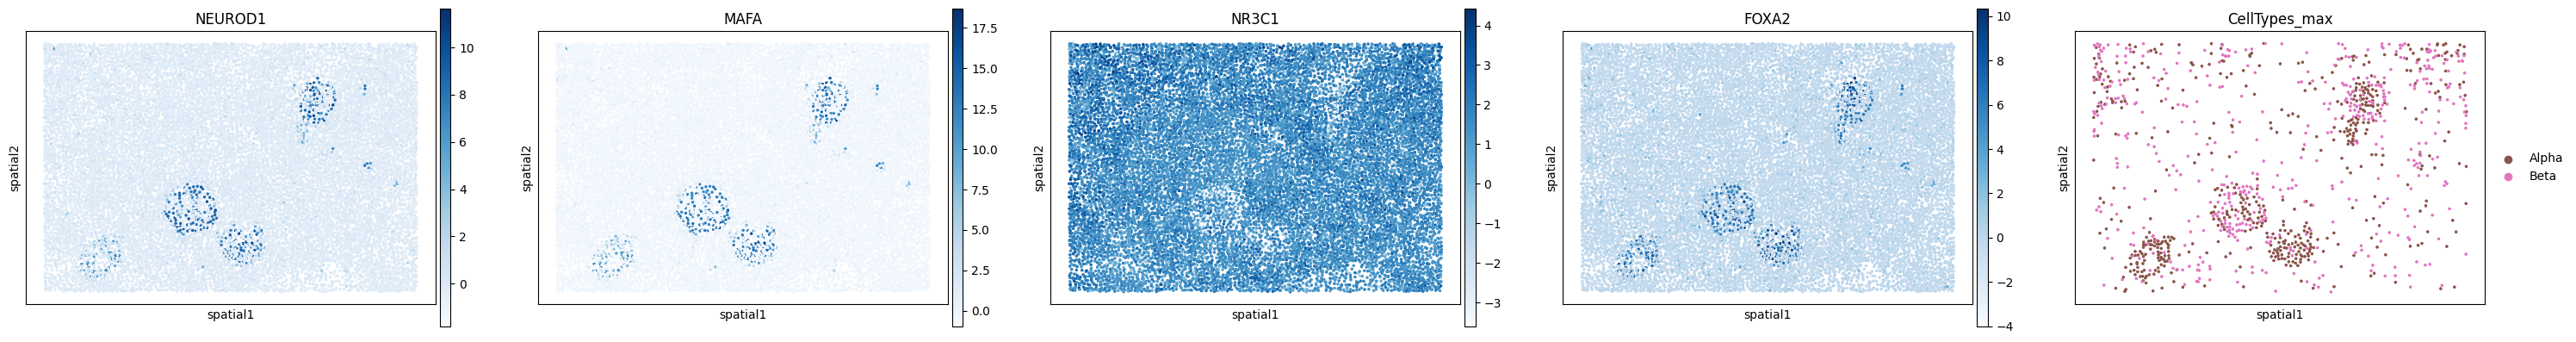

In [42]:
sq.pl.spatial_scatter(
    acts_2[acts_2.obs['fov'] == '10'],
    color = ['NEUROD1', 'MAFA','NR3C1','FOXA2','CellTypes_max'],
    groups = ['Alpha','Beta','Delta'],
    spatial_key = 'spatial',
    shape=None,
    cmap='Blues',
    ncols=6,
    #vmax="p99",
)

### Evaluation using TF activities estimated with own GRN

In [19]:
# Define the new order of cell type categories
new_order = ['Acinar_basal', 'Acinar_highEnz','Acinar_signal','Acinar_sigdiff',
            'Ductal','Beta','Alpha','Activated_Stellate',
            'Quiescent_Stellate','Endothelial','Macrophage','Tcells']

# Reorder cell type categories
adata.obs['CellTypes_max'] = adata.obs['CellTypes_max'].astype('category')
acts.obs['CellTypes_max'] = acts.obs['CellTypes_max'].astype('category')
adata.obs['CellTypes_max'] = adata.obs['CellTypes_max'].cat.reorder_categories(new_order, ordered=True)
acts.obs['CellTypes_max'] = acts.obs['CellTypes_max'].cat.reorder_categories(new_order, ordered=True)

adata.uns['CellTypes_max_colors'] = [
    '#2E8B57', #Acinar_basal
    '#355E3B', #Acinar_highEnz
    '#9FE2BF', #Acinar_signal
    '#009E60', #Acinar_sigdiff
    '#89CFF0', #Ductal
    #'#7393B3', #MUC5b_Ductal
    '#CBC3E3', #Beta
    '#AA98A9', #Alpha
    #'#CF9FFF', #Delta
    '#E35335', #Activated_Stellate
    '#F89880', #Quiescent_Stellate
    '#FFDB58', #Endothelial
    '#770737', #Macrophage
    '#FF2400', #Tcells
]

acts.uns['CellTypes_max_colors'] = adata.uns['CellTypes_max_colors']

In [20]:
acts.X[~np.isfinite(acts.X)] = 0

In [23]:
acts, adata

(AnnData object with n_obs × n_vars = 368788 × 366
     obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse', 'CellTypes_max', 'donor', 'cell_type', 'leiden_covet_0.2', 'Niche_label', 'fov_unique'
     uns: 'Niche_label_colors', 'hvg', 'leiden_covet_0.2', 'n_neighbors=30', 'neighbors', 'pca', 'spatial', 'spatial_neighbors', 'CellTypes_max_colors'
     obsm: 'X_pca', 'X_umap', 'covet-n_neighbors=30', 'covet_sqrt-n_neighbors=30', 'covet_sqrt_flat-n_neighbors=30', 'spat

In [24]:
acts.obsp['spatial_connectivities'] = adata.obsp['spatial_connectivities']
acts

AnnData object with n_obs × n_vars = 368788 × 366
    obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse', 'CellTypes_max', 'donor', 'cell_type', 'leiden_covet_0.2', 'Niche_label', 'fov_unique'
    uns: 'Niche_label_colors', 'hvg', 'leiden_covet_0.2', 'n_neighbors=30', 'neighbors', 'pca', 'spatial', 'spatial_neighbors', 'CellTypes_max_colors'
    obsm: 'X_pca', 'X_umap', 'covet-n_neighbors=30', 'covet_sqrt-n_neighbors=30', 'covet_sqrt_flat-n_neighbors=30', 'spatial'

In [25]:
results_file = '/lustre/groups/ml01/workspace/sara.jimenez/spatial_pancreas_data/preprocessed_data/data4downstream/TF_activities_all_slides.h5ad'
acts.write(results_file)

... storing 'cell_type_coarse' as categorical
... storing 'cell_type' as categorical


In [26]:
df = dc.rank_sources_groups(acts, groupby='CellTypes_max', reference='rest', method='t-test_overestim_var')
df

group reference    names   statistic  meanchange  pvals  \
0     Acinar_basal      rest  BHLHA15  375.130010    1.291169    0.0   
1     Acinar_basal      rest    NR1D1  250.683710    2.524871    0.0   
2     Acinar_basal      rest     GFI1  246.126242    1.760049    0.0   
3     Acinar_basal      rest    CREB3  243.325415    2.905259    0.0   
4     Acinar_basal      rest      NRL  239.884083    1.846687    0.0   
...            ...       ...      ...         ...         ...    ...   
4387        Tcells      rest    HNF4G -203.602750   -2.079994    0.0   
4388        Tcells      rest      MNT -204.783100   -2.282951    0.0   
4389        Tcells      rest    ZNF24 -207.292274   -2.487072    0.0   
4390        Tcells      rest    TFAP4 -213.638814   -2.516818    0.0   
4391        Tcells      rest     RORA -227.979191   -2.272883    0.0   

      pvals_adj  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0  
...         ...  
4387        0.0  
4388        0.0  
4389        0.0  
4390        0.0  
4391        0.0  

[4392 rows x 7 columns]

In [27]:
df.to_csv('ranked_tfs_by_celltype_t-test_overestim_var.tsv', sep='\t', index=False)

In [28]:
n_markers = 2
source_markers = df.groupby('group').head(n_markers).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
source_markers

{'Acinar_basal': ['BHLHA15', 'NR1D1'],
 'Acinar_highEnz': ['GFI1', 'ZNF528'],
 'Acinar_sigdiff': ['ZBTB7B', 'NFIC'],
 'Acinar_signal': ['ETV7', 'POU5F1'],
 'Activated_Stellate': ['HAND2', 'OSR2'],
 'Alpha': ['NEUROD1', 'PAX3'],
 'Beta': ['RXRG', 'PAX6'],
 'Ductal': ['SOX8', 'ZNF667'],
 'Endothelial': ['HOXD8', 'MEOX2'],
 'Macrophage': ['RREB1', 'FOXC1'],
 'Quiescent_Stellate': ['TWIST1', 'TBX18'],
 'Tcells': ['TBX21', 'RUNX3']}

In [29]:
tf_markers = ['BHLHA15', 'NR1D1', 'GFI1', 'ZNF528', 'ETV7', 'POU5F1', 'ZBTB7B', 'NFIC', 'SOX8', 'ZNF667', 'RXRG', 'PAX6','NEUROD1', 'PAX3','HAND2', 'OSR2','TWIST1', 'TBX18','HOXD8', 'MEOX2','RREB1', 'FOXC1','TBX21', 'RUNX3']

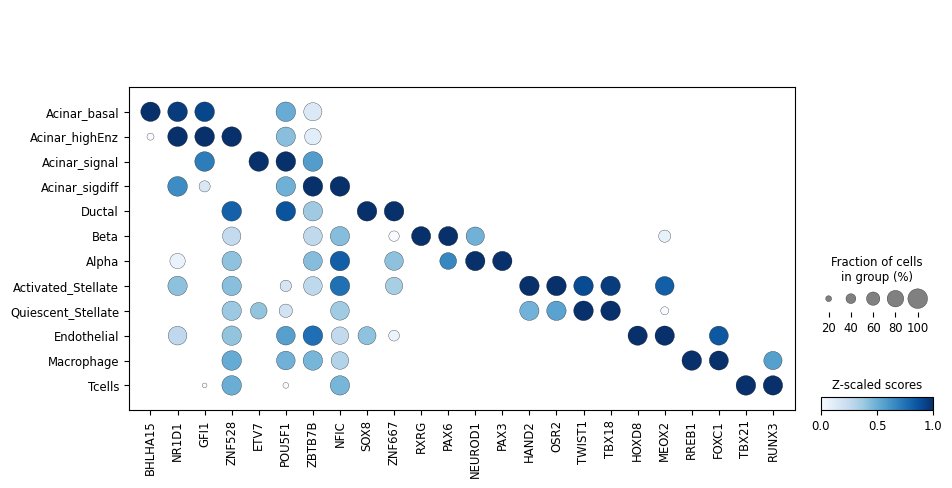

In [30]:
sc.pl.dotplot(acts, tf_markers, 'CellTypes_max', standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='Blues',save='top2_tfs_by_celltype.pdf')

In [31]:
df_cond = dc.rank_sources_groups(acts, groupby='condition', reference='rest', method='t-test_overestim_var')
n_markers = 10
source_markers_cond = df_cond.groupby('group').head(n_markers).groupby('group')['names'].apply(lambda x: list(x)).to_dict()
source_markers_cond

{'ND': ['PAX6',
  'YY2',
  'GLI3',
  'MAFA',
  'INSM1',
  'NEUROD1',
  'RXRG',
  'MNX1',
  'ATF7',
  'SCRT1'],
 'T1D': ['ZNF354C',
  'ZNF684',
  'ESRRA',
  'STAT3',
  'RBPJ',
  'HNF4A',
  'TCF3',
  'FOSL2',
  'THRB',
  'JUND']}

In [32]:
df_cond.to_csv('ranked_tfs_by_condition_t-test_overestim_var.tsv', sep='\t', index=False)

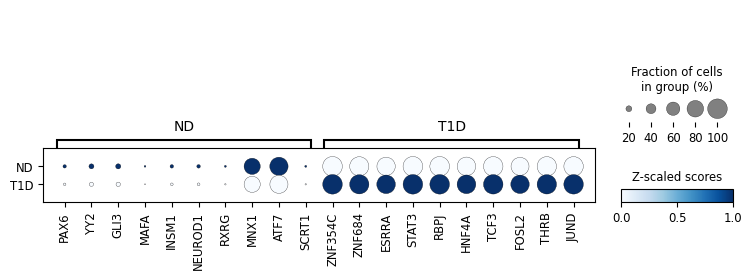

In [33]:
sc.pl.dotplot(acts, source_markers_cond, 'condition', standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='Blues',save='top10_tfs_by_condition.pdf')

In [36]:
acts.obs['slide']

2_1        Run5211_S1
6_1        Run5211_S1
18_1       Run5211_S1
32_1       Run5211_S1
38_1       Run5211_S1
              ...    
7142_25    Run5211_S3
7152_25    Run5211_S3
7177_25    Run5211_S3
7181_25    Run5211_S3
7216_25    Run5211_S3
Name: slide, Length: 368788, dtype: category
Categories (3, object): ['Run5211_S1', 'Run5211_S2', 'Run5211_S3']

In [ ]:
sq.pl.spatial_scatter(
    acts[acts.obs['fov_unique'] == '12_Run5211_S1'],
    color = ['PAX6','YY2','GLI3','MAFA','INSM1','NEUROD1','RXRG','MNX1','ATF7','CellTypes_max'],
    groups = ['Beta','Alpha'],
    spatial_key = 'spatial',
    shape=None,
    cmap='Blues',
    ncols=5,
    #vmax="p99",
)

/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/squidpy/pl/_color_utils.py:28: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
/home/aih/sara.jimenez/miniconda3/envs/liana/lib/python3.9/site-packages/squidpy/pl/_spatial_utils.py:946: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored


#### Spatially variable activities

In [84]:
acts.obsp['spatial_connectivities'] = adata.obsp['spatial_connectivities']

In [ ]:
df_svg = sq.gr.spatial_autocorr(acts,
                                mode="moran",
                                n_perms=100,
                                n_jobs=4,
                                seed=0,
                                copy=True
                               )
acts

In [83]:
acts,adata

(AnnData object with n_obs × n_vars = 368788 × 366
     obs: 'fov', 'Area', 'AspectRatio', 'CenterX_global_px', 'CenterY_global_px', 'Width', 'Height', 'Mean.MembraneStain', 'Max.MembraneStain', 'Mean.PanCK', 'Max.PanCK', 'Mean.GCG', 'Max.GCG', 'Mean.CD3', 'Max.CD3', 'Mean.DAPI', 'Max.DAPI', 'cell_ID', 'condition', 'slide', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_NegPrb', 'log1p_total_counts_NegPrb', 'pct_counts_NegPrb', 'n_genes', 'cell_type_coarse', 'CellTypes_max', 'donor', 'cell_type', 'leiden_covet_0.2', 'Niche_label', 'fov_unique'
     uns: 'Niche_label_colors', 'hvg', 'leiden_covet_0.2', 'n_neighbors=30', 'neighbors', 'pca', 'spatial', 'spatial_neighbors', 'dendrogram_CellTypes_max', 'CellTypes_max_colors'
     obsm: 'X_pca', 'X_umap', 'covet-n_neighbors=30', 'covet_sqrt-n_neighbors=30', 'covet_sqrt